[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/nbs/total_variation_denoising.ipynb)
<a href="https://huggingface.co/spaces/kornia/total_variation_denoising"><img src="https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Spaces-blue.svg" alt="pypi version"></a>

# Denoise image using total variation


In this tutorial we are going to learn how to denoise an image using the differentiable `total_variation` loss.

In [ ]:
%%capture
!pip install kornia
!pip install kornia-rs

In [ ]:
import io

import requests


def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename


url = "https://github.com/kornia/data/raw/main/doraemon.png"
download_image(url)

'doraemon.png'

In [ ]:
import kornia as K
import matplotlib.pyplot as plt
import torch
import torchvision

In [ ]:
def imshow(input: torch.Tensor):
    out = torchvision.utils.make_grid(input, nrow=2, padding=5)
    out_np = K.utils.tensor_to_image(out)
    plt.imshow(out_np)
    plt.axis("off")
    plt.show()

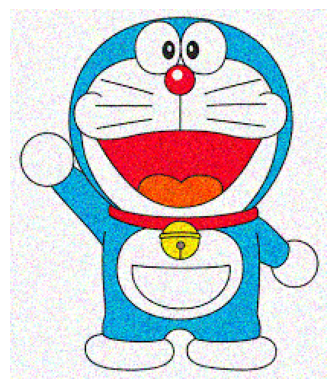

In [ ]:
# read the image with kornia and add a random noise to it
img = K.io.load_image("doraemon.png", K.io.ImageLoadType.RGB32)  # CxHxW

noisy_image = (img + torch.normal(torch.zeros_like(img), 0.1)).clamp(0, 1)
imshow(noisy_image)

We define the total variation denoising network and the optimizer

In [ ]:
# define the total variation denoising network
class TVDenoise(torch.nn.Module):
    def __init__(self, noisy_image):
        super().__init__()
        self.l2_term = torch.nn.MSELoss(reduction="mean")
        self.regularization_term = K.losses.TotalVariation()
        # create the variable which will be optimized to produce the noise free image
        self.clean_image = torch.nn.Parameter(data=noisy_image.clone(), requires_grad=True)
        self.noisy_image = noisy_image

    def forward(self):
        return self.l2_term(self.clean_image, self.noisy_image) + 0.0001 * self.regularization_term(self.clean_image)

    def get_clean_image(self):
        return self.clean_image


tv_denoiser = TVDenoise(noisy_image)

# define the optimizer to optimize the 1 parameter of tv_denoiser
optimizer = torch.optim.SGD(tv_denoiser.parameters(), lr=0.1, momentum=0.9)

Run the the optimization loop

In [ ]:
num_iters: int = 500
for i in range(num_iters):
    optimizer.zero_grad()
    loss = tv_denoiser().sum()
    if i % 50 == 0:
        print(f"Loss in iteration {i} of {num_iters}: {loss.item():.3f}")
    loss.backward()
    optimizer.step()

Loss in iteration 0 of 500: 3.081
Loss in iteration 50 of 500: 2.723
Loss in iteration 100 of 500: 2.359
Loss in iteration 150 of 500: 2.064
Loss in iteration 200 of 500: 1.828
Loss in iteration 250 of 500: 1.642
Loss in iteration 300 of 500: 1.497
Loss in iteration 350 of 500: 1.384
Loss in iteration 400 of 500: 1.297
Loss in iteration 450 of 500: 1.229


Visualize the noisy and resulting cleaned image

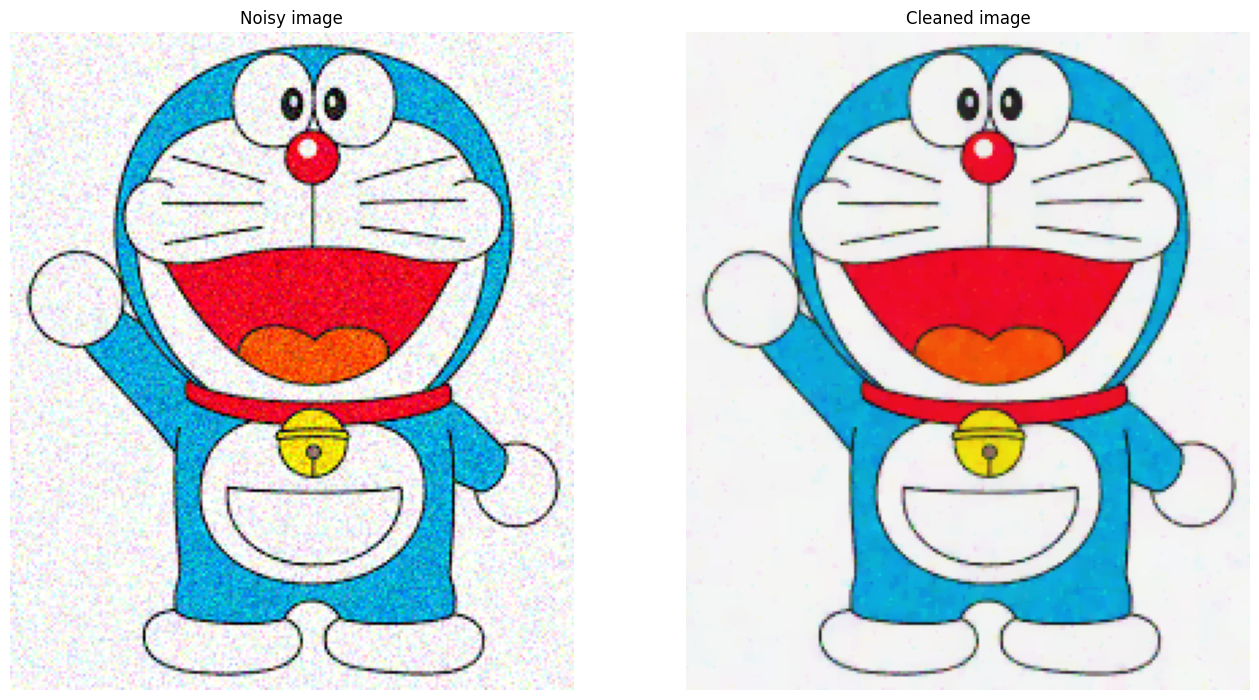

In [ ]:
# convert back to numpy
img_clean = K.utils.tensor_to_image(tv_denoiser.get_clean_image())

# Create the plot
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
axs = axs.ravel()

axs[0].axis("off")
axs[0].set_title("Noisy image")
axs[0].imshow(K.tensor_to_image(noisy_image))

axs[1].axis("off")
axs[1].set_title("Cleaned image")
axs[1].imshow(img_clean)

plt.show()